In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)

from sklearn.metrics import confusion_matrix
import itertools

import tensorflow as tf
tf.compat.v1.disable_v2_behavior
from tensorflow import keras
from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:

import shutil

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import os
from glob import glob
from PIL import Image

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K

%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML


In [6]:
#@title Default title text
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
y_train = np.load("/content/drive/MyDrive/SAVE/y_train.npy")
x_train = np.load("/content/drive/MyDrive/SAVE/x_train.npy")

In [ ]:
x_validate = np.load("/content/drive/MyDrive/SAVE/x_validate.npy")
y_validate = np.load("/content/drive/MyDrive/SAVE/y_validate.npy")

In [ ]:
x_test = np.load("/content/drive/MyDrive/SAVE/x_test.npy")
y_test = np.load("/content/drive/MyDrive/SAVE/y_test.npy")

In [ ]:
y_test

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
import numpy as np
y = np.argmax(y_test)


In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Ham10000/ReorganizeD",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=batch_size
)


Found 8758 files belonging to 7 classes.


In [9]:
class_names = dataset.class_names
class_names

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [10]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())


(32, 256, 256, 3)
[4 2 1 4 3 0 2 3 2 2 0 0 2 1 1 3 3 4 0 0 0 6 3 5 4 0 5 3 1 1 6 4]


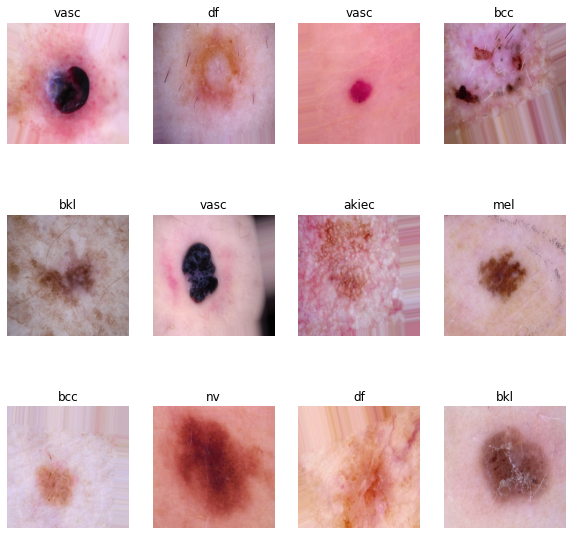

In [11]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


In [7]:
IMAGE_SIZE = 256
CHANNELS = 3
batch_size=32

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split
train_dir = os.getcwd() + "/drive/MyDrive/Ham10000/ReorganizeD"
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data
validation_generator = train_datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 7010 images belonging to 7 classes.
Found 1748 images belonging to 7 classes.


In [13]:
import tensorflow
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, \
     Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate

In [14]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K

def densenet(input_shape, n_classes, filters = 32):
    

    def bn_rl_conv(x,filters,kernel=1,strides=1):
        
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
        return x
    
    def dense_block(x, repetition):
        
        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x
        
    def transition_layer(x):
        
        x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x
    
    input = Input (input_shape)
    x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)
    
    for repetition in [6,12,48,32]:
        
        d = dense_block(x, repetition)
        x = transition_layer(d)
    x = GlobalAveragePooling2D()(d)
 
    output = Dense(n_classes, activation = 'softmax')(x)
    
    model = Model(input, output)
    return model
input_shape = 256, 256, 3
n_classes = 7
model = densenet(input_shape,n_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 64)   0           ['conv2d[0][0]']                 
                                                                                              

In [15]:
from tensorflow.keras.optimizers import Adam, SGD
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#optimizer = SGD(lr=0.001, momentum=15, decay=0.0, nesterov=False)
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10)

In [ ]:
datagen.fit(x_train)
## Fit the model
epochs = 40
batch_size = 64

datagen.fit(x_validate)
history = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),verbose = 1,
                              epochs = epochs, validation_data = datagen.flow(x_validate,y_validate),callbacks=[learning_rate_reduction])


Epoch 1/40
99/99 [==============================] - 113s 916ms/step - loss: 1.9896 - accuracy: 0.3540 - val_loss: 20.1883 - val_accuracy: 0.1184 - lr: 0.0010
Epoch 2/40
99/99 [==============================] - 87s 881ms/step - loss: 1.4598 - accuracy: 0.4327 - val_loss: 2.4736 - val_accuracy: 0.1384 - lr: 0.0010
Epoch 3/40
99/99 [==============================] - 88s 886ms/step - loss: 1.3524 - accuracy: 0.4715 - val_loss: 2.4551 - val_accuracy: 0.2240 - lr: 0.0010
Epoch 4/40
99/99 [==============================] - 88s 884ms/step - loss: 1.3144 - accuracy: 0.4901 - val_loss: 2.2397 - val_accuracy: 0.2939 - lr: 0.0010
Epoch 5/40
99/99 [==============================] - 87s 881ms/step - loss: 1.2953 - accuracy: 0.4988 - val_loss: 3.9603 - val_accuracy: 0.3295 - lr: 0.0010
Epoch 6/40
99/99 [==============================] - 88s 882ms/step - loss: 1.2278 - accuracy: 0.5190 - val_loss: 1.6197 - val_accuracy: 0.3880 - lr: 0.0010
Epoch 7/40
99/99 [==============================] - 87s 881ms/

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=219,
    batch_size=32,
    validation_data=validation_generator,
    validation_steps=54,
    verbose=1,
    epochs=40,callbacks=[learning_rate_reduction]
)


Epoch 1/40
 35/219 [===>..........................] - ETA: 42:06 - loss: 3.3575 - accuracy: 0.2920

In [16]:
7010/32

219.0625

In [17]:
1748/32

54.625

In [ ]:
datagen.fit(x_train)
## Fit the model
epochs = 40
batch_size = 64

datagen.fit(x_validate)
history = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),verbose = 1,
                              epochs = epochs, validation_data = datagen.flow(x_validate,y_validate),callbacks=[learning_rate_reduction])

Epoch 1/40


ValueError: ignored

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=0)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

Validation: accuracy = 0.771755  ;  loss_v = 0.652851
Test: accuracy = 0.791096  ;  loss = 0.634234


In [ ]:
model.save("/content/drive/MyDrive/Densenet201.h5")